# Fresh Products

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import sys

# Move two levels up (to the project root) and append the `src` folder
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Append src to sys.path
sys.path.append(src_path)

from src import query_engines, dataframe_visualizer

q = query_engines.QueryEngines()

## Q1: Identify all kinds of segmentation

### What is the distribution of segments_lvl 1?

In [3]:
QUERY_NAME = 'possible_segmentations.sql'

q.prepare_query(
    QUERY_NAME
    ,params=None
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
)

possible_segmentations  = q.query_run_starburst()

grouped = possible_segmentations.groupby('segment_1').agg(
    distinct_sad_id = ('store_address_id','nunique'),
    migrated_sad_id = ('is_migrated', lambda x: x.sum())
).reset_index()

grouped['perc_migrated_store_address_id'] = grouped['migrated_sad_id']/grouped['distinct_sad_id']
grouped.sort_values(by='distinct_sad_id', ascending=False)

,segment_1,distinct_sad_id,migrated_sad_id,perc_migrated_store_address_id
2,Specialties,15552,1885,0.121206
3,Top Partner,10793,8655,0.801909
1,Non Top Partner,5914,1922,0.324992
0,MFC,228,219,0.960526


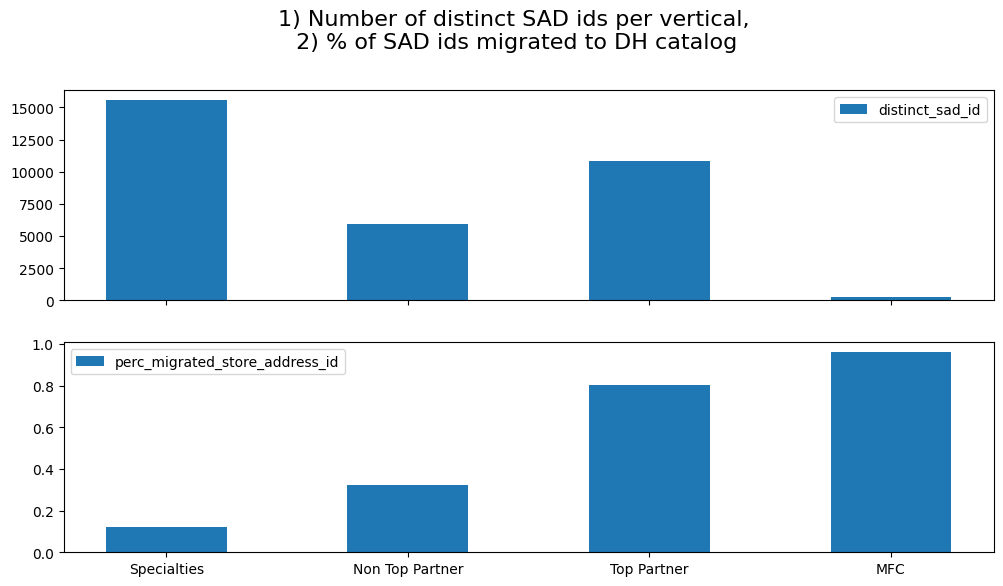

In [4]:
tmp = grouped.copy()
tmp.sort_values(by='perc_migrated_store_address_id',inplace=True)
                                                       
v = dataframe_visualizer.DataFrameVisualizer(tmp)

plot_params = [
    {
        'plot_type': 'barplot',
        'x_column': 'segment_1',
        'y_columns': ['distinct_sad_id'],
        'legend': True,
        'bar_width': 0.5
    },
    {
        'plot_type': 'barplot',
        'x_column': 'segment_1',
        'y_columns': ['perc_migrated_store_address_id'],
        'legend': True,
        'bar_width': 0.5
    },
]

# Define figure parameters
figure_params = {
    'n_plots': 2,
    'fig_length': 12, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 0,   
    'share_x': True,   
    'title': '1) Number of distinct SAD ids per vertical,\n 2) % of SAD ids migrated to DH catalog'
}

v.plot(figure_params=figure_params, plot_params=plot_params)

In [5]:
grouped = possible_segmentations.groupby('segment_2').agg(
    distinct_sad_id = ('store_address_id','nunique'),
    migrated_sad_id = ('is_migrated', lambda x: x.sum())
).reset_index()

grouped['perc_m'] = grouped['migrated_sad_id']/grouped['distinct_sad_id']
grouped.sort_values(by='distinct_sad_id', ascending=False)

,segment_2,distinct_sad_id,migrated_sad_id,perc_m
0,Groceries Partner,16707,10577,0.633088
2,Specialties,15552,1885,0.121206
1,MFC,228,219,0.960526


# Q2: Fresh products category

In [13]:
QUERY_NAME = 'fresh_products_category.sql'
START_DATE = "'2024-07-01'"
END_DATE = "'2024-11-01'"

params = [
    {'name':'start_date','value':START_DATE},
    {'name':'end_date','value':END_DATE},
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=None
)

df = q.query_run_starburst()

/Users/jordicremades/Documents/repos/central-node/src/query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/3cecbcb4c7221d3c9ad89095a7074be6d3b0105d6565893ad64cd5473a30744c


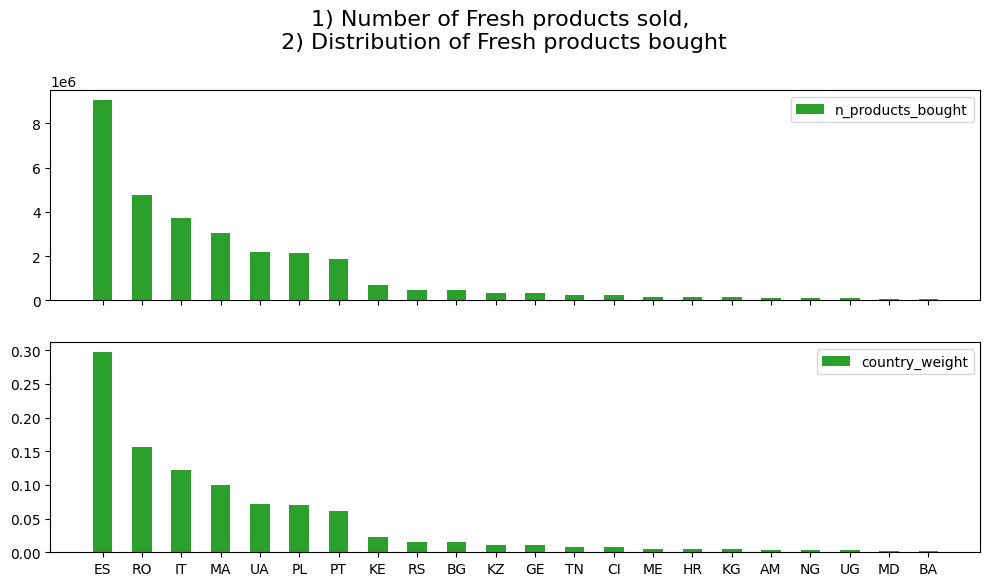

In [35]:
# Which are the most important countries in terms of 
grouped = df.groupby('country_code')['n_products_bought'].sum().reset_index()
grouped['country_weight'] = grouped['n_products_bought']/grouped['n_products_bought'].sum()
grouped.sort_values(by='country_weight', ascending=False, inplace=True)

tmp = grouped.copy()
                                                       
v = dataframe_visualizer.DataFrameVisualizer(tmp)

plot_params = [
    {
        'plot_type': 'barplot',
        'x_column': 'country_code',
        'y_columns': ['n_products_bought'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['green']
    },
    {
        'plot_type': 'barplot',
        'x_column': 'country_code',
        'y_columns': ['country_weight'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['green']
    },
]

# Define figure parameters
figure_params = {
    'n_plots': 2,
    'fig_length': 12, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 0,   
    'share_x': True,   
    'title': '1) Number of Fresh products sold,\n 2) Distribution of Fresh products bought'
}

v.plot(figure_params=figure_params, plot_params=plot_params)

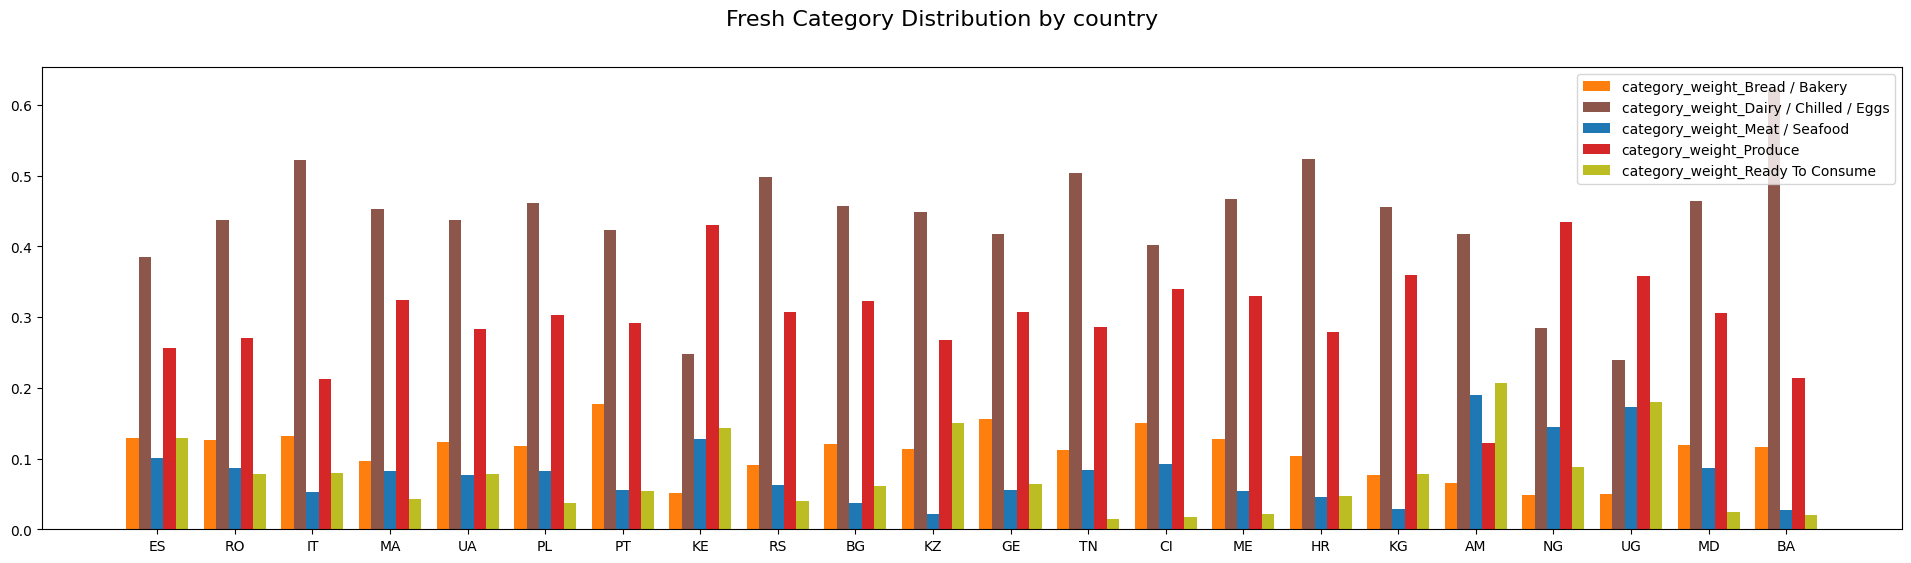

In [80]:
# Which are the most important categories
grouped = df.groupby(['product_category_level_one','country_code'])['n_products_bought'].sum().reset_index()
country_totals = grouped.groupby('country_code')['n_products_bought'].sum().reset_index()
country_totals.rename(columns={'n_products_bought':'total_products_sold'}, inplace=True)
merged = pd.merge(grouped, country_totals, on='country_code', how='left')
merged['category_weight'] = merged['n_products_bought']/merged['total_products_sold']

pivoted = merged.pivot(index='country_code', columns='product_category_level_one', values=['category_weight'])
pivoted.columns = [f'{col[0]}_{col[1]}' for col in pivoted.columns]
pivoted = pivoted.reset_index()
pivoted_ranked = pd.merge(pivoted, country_totals, on='country_code', how='left')
pivoted_ranked.sort_values(by='total_products_sold', ascending=False, inplace=True)

tmp = pivoted_ranked.copy()

v = dataframe_visualizer.DataFrameVisualizer(tmp)

plot_params = [
    {
        'plot_type': 'barplot',
        'x_column': 'country_code',
        'y_columns': ['category_weight_Bread / Bakery','category_weight_Dairy / Chilled / Eggs','category_weight_Meat / Seafood','category_weight_Produce','category_weight_Ready To Consume'],
        'legend': True,
        'bar_width': 0.8,
        'colors': ['orange','brown','blue','red','olive']
    },
]

# Define figure parameters
figure_params = {
    'n_plots': 1,
    'fig_length': 24, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 0,   
    'share_x': True,   
    'title': 'Fresh Category Distribution by country'
}

v.plot(figure_params=figure_params, plot_params=plot_params)

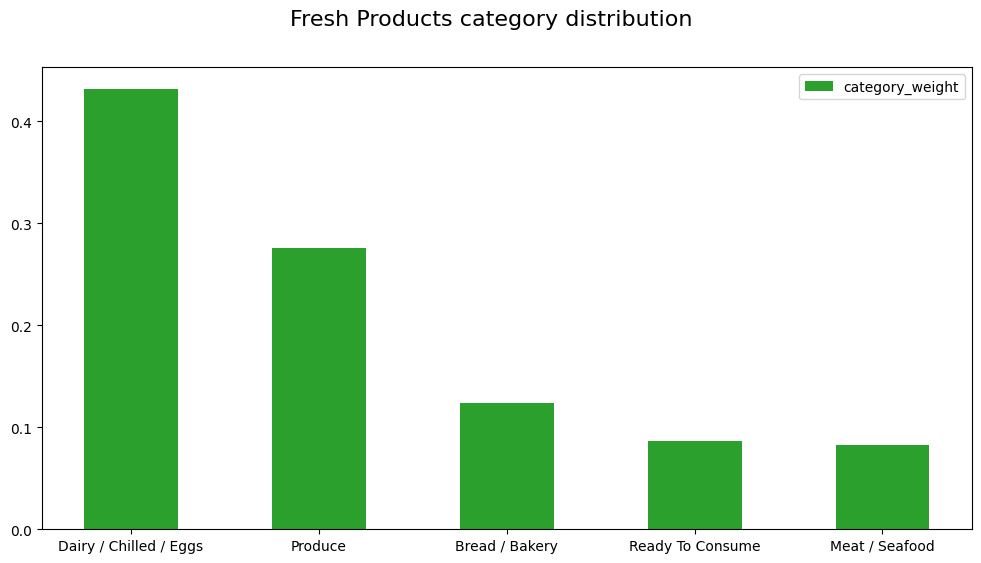

In [103]:
# Which are the most important categories
grouped = df.groupby('product_category_level_one')['n_products_bought'].sum().reset_index()
grouped['category_weight'] = grouped['n_products_bought']/grouped['n_products_bought'].sum()
grouped.sort_values(by='category_weight', ascending=False, inplace=True)

tmp = grouped.copy()
                                                       
v = dataframe_visualizer.DataFrameVisualizer(tmp)

plot_params = [
    {
        'plot_type': 'barplot',
        'x_column': 'product_category_level_one',
        'y_columns': ['category_weight'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['green']
    },
]

# Define figure parameters
figure_params = {
    'n_plots': 1,
    'fig_length': 12, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 0,   
    'share_x': True,   
    'title': 'Fresh Products category distribution'
}

v.plot(figure_params=figure_params, plot_params=plot_params)

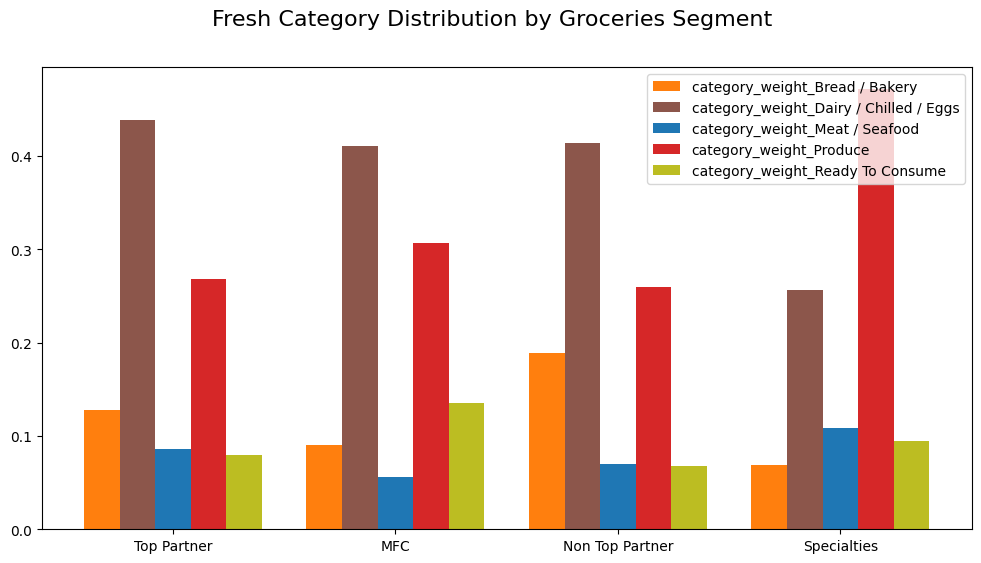

In [115]:
# Which are the most important categories
grouped = df.groupby(['product_category_level_one','segment_1'])['n_products_bought'].sum().reset_index()
segment_totals = grouped.groupby('segment_1')['n_products_bought'].sum().reset_index()
segment_totals.rename(columns={'n_products_bought':'total_products_sold'}, inplace=True)
merged = pd.merge(grouped, segment_totals, on='segment_1', how='left')
merged['category_weight'] = merged['n_products_bought']/merged['total_products_sold']

pivoted = merged.pivot(index='segment_1', columns='product_category_level_one', values=['category_weight'])
pivoted.columns = [f'{col[0]}_{col[1]}' for col in pivoted.columns]
pivoted = pivoted.reset_index()
pivoted_ranked = pd.merge(pivoted, segment_totals, on='segment_1', how='left')
pivoted_ranked.sort_values(by='total_products_sold', ascending=False, inplace=True)

tmp = pivoted_ranked.copy()

v = dataframe_visualizer.DataFrameVisualizer(tmp)

plot_params = [
    {
        'plot_type': 'barplot',
        'x_column': 'segment_1',
        'y_columns': ['category_weight_Bread / Bakery','category_weight_Dairy / Chilled / Eggs','category_weight_Meat / Seafood','category_weight_Produce','category_weight_Ready To Consume'],
        'legend': True,
        'bar_width': 0.8,
        'colors': ['orange','brown','blue','red','olive']
    },
]

# Define figure parameters
figure_params = {
    'n_plots': 1,
    'fig_length': 12, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 0,   
    'share_x': True,   
    'title': 'Fresh Category Distribution by Groceries Segment'
}

v.plot(figure_params=figure_params, plot_params=plot_params)

# Q3: Rest of metrics

In [116]:
QUERY_NAME = 'metrics.sql'
START_DATE = "'2024-07-01'"
END_DATE = "'2024-10-15'"
END_DATE_RETENTION = "'2024-11-15'"

params = [
    {'name':'start_date','value':START_DATE},
    {'name':'end_date','value':END_DATE},
    {'name':'end_date_retention','value':END_DATE_RETENTION}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
)

metrics  = q.query_run_starburst()

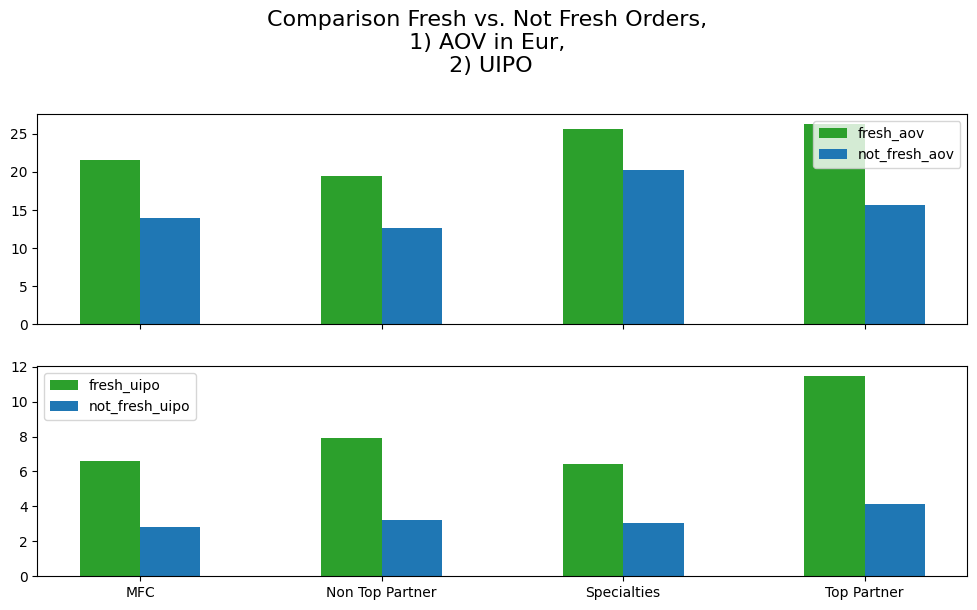

In [144]:
# AOV
grouped = metrics.groupby('segment_1')[['fo_gmv','nfo_gmv','f_orders','nf_orders','n_uipo_fresh_orders','n_uipo_not_fresh_orders']].sum().reset_index()
grouped['fresh_aov'] = grouped['fo_gmv']/grouped['f_orders']
grouped['not_fresh_aov'] = grouped['nfo_gmv']/grouped['nf_orders']
grouped['fresh_uipo'] = grouped['n_uipo_fresh_orders']/grouped['f_orders']
grouped['not_fresh_uipo'] = grouped['n_uipo_not_fresh_orders']/grouped['nf_orders']
grouped

tmp = grouped.copy()
                                                       
v = dataframe_visualizer.DataFrameVisualizer(tmp)

plot_params = [
    {
        'plot_type': 'barplot',
        'x_column': 'segment_1',
        'y_columns': ['fresh_aov','not_fresh_aov'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['green','blue']
    },
        {
        'plot_type': 'barplot',
        'x_column': 'segment_1',
        'y_columns': ['fresh_uipo','not_fresh_uipo'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['green','blue']
    },
]

# Define figure parameters
figure_params = {
    'n_plots': 2,
    'fig_length': 12, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 0,   
    'share_x': True,   
    'title': 'Comparison Fresh vs. Not Fresh Orders,\n 1) AOV in Eur, \n 2) UIPO'
}

v.plot(figure_params=figure_params, plot_params=plot_params)

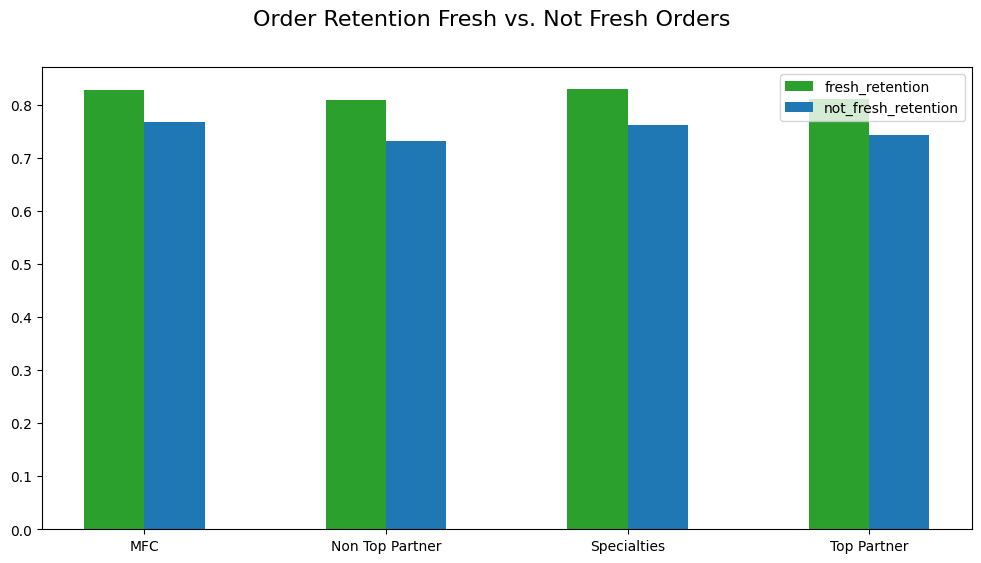

In [ ]:
# AOV
grouped = metrics.groupby('segment_1')[['nf_orders','f_orders','f_orders_retained_Groceries','nf_orders_retained_Groceries']].sum().reset_index()
grouped['fresh_retention'] = grouped['f_orders_retained_Groceries']/grouped['f_orders']
grouped['not_fresh_retention'] = grouped['nf_orders_retained_Groceries']/grouped['nf_orders']
grouped

tmp = grouped.copy()
                                                       
v = dataframe_visualizer.DataFrameVisualizer(tmp)

plot_params = [
    { 
        'plot_type': 'barplot',
        'x_column': 'segment_1',
        'y_columns': ['fresh_retention','not_fresh_retention'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['green','blue']
    }
]

# Define figure parameters
figure_params = {
    'n_plots': 1,
    'fig_length': 12, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 0,   
    'share_x': True,   
    'title': 'Order Retention Fresh vs. Not Fresh Orders'
}

v.plot(figure_params=figure_params, plot_params=plot_params)

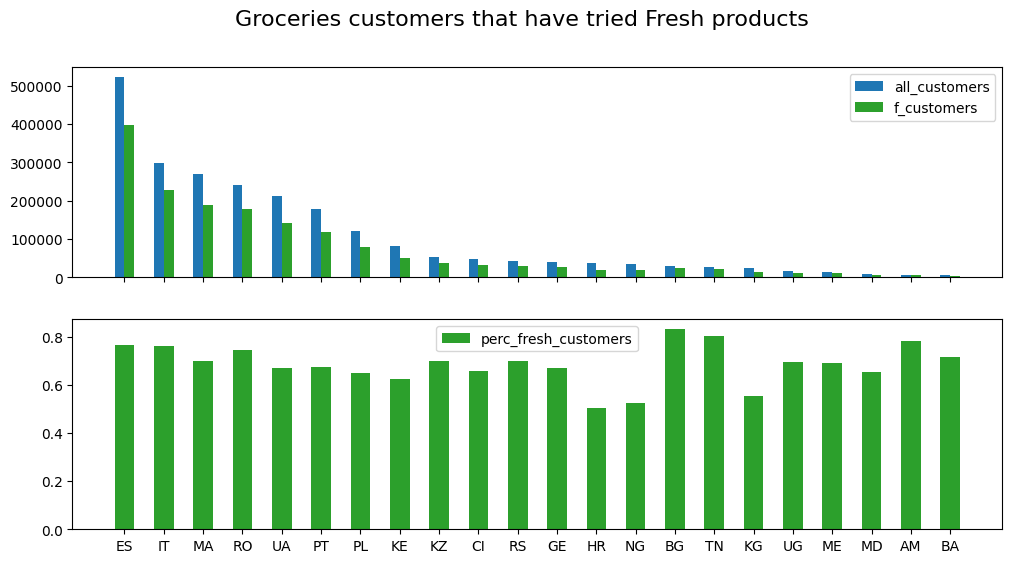

In [156]:
# Customers that have tried fresh
grouped = metrics.groupby('country')[['all_customers','f_customers']].sum().reset_index()
grouped['perc_fresh_customers'] = grouped['f_customers']/grouped['all_customers']
tmp = grouped.copy()
tmp.sort_values(by='all_customers',ascending=False,inplace=True)

v = dataframe_visualizer.DataFrameVisualizer(tmp)

plot_params = [
    {
        'plot_type': 'barplot',
        'x_column': 'country',
        'y_columns': ['all_customers','f_customers'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['blue','green']
    },
    {
        'plot_type': 'barplot',
        'x_column': 'country',
        'y_columns': ['perc_fresh_customers'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['green']
    }

]

# Define figure parameters
figure_params = {
    'n_plots': 2,
    'fig_length': 12, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 0,   
    'share_x': True,   
    'title': 'Groceries customers that have tried Fresh products'
}

v.plot(figure_params=figure_params, plot_params=plot_params)

## Q4: Product metrics

In [161]:
QUERY_NAME = 'metrics_product.sql'
START_DATE = "'2024-07-01'"
END_DATE = "'2024-10-15'"
END_DATE_RETENTION = "'2024-11-15'"

params = [
    {'name':'start_date','value':START_DATE},
    {'name':'end_date','value':END_DATE},
    {'name':'end_date_retention','value':END_DATE_RETENTION}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=None
)

metrics_product  = q.query_run_starburst()

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/ed907b0d29883fb47357c0d70d8914e673d1974b8df3fe01b80a4fd9bb5bb9e8


In [162]:
metrics_product.head()

,country,segment_1,segment_2,all_customers,f_customers,nf_customers,all_orders,f_orders,nf_orders,all_gmv,...,f_orders_with_pna,nf_orders_with_pna,pna_all_products,f_products_with_pna,nf_products_with_pna,all_products,f_products,nf_products,n_distinct_bought_product_ids,_col25
0,RO,Top Partner,Groceries Partner,222354,169354,116671,1154387,834529,319858,3.242675e+07,...,210102,34848,408820,141317,267503,10465034,3839838,6625196,10465034,10465034
1,ME,Top Partner,Groceries Partner,6433,5134,2677,22829,17754,5075,6.053958e+05,...,8202,1410,17120,5186,11934,225241,83293,141948,225241,225241
2,NG,Specialties,Specialties,1537,545,1120,2833,1105,1728,2.383018e+04,...,52,121,224,55,169,5848,2253,3595,5848,5848
3,KG,MFC,MFC,12507,6504,8794,41723,19819,21904,5.228877e+05,...,1164,398,1994,771,1223,189955,60758,129197,189955,189955
4,BG,Specialties,Specialties,4394,2156,2898,10706,4917,5789,2.517670e+05,...,1280,580,2475,619,1856,53301,15676,37625,53301,53301


In [ ]:
# AOV
grouped = metrics.groupby('segment_1')[['fo_gmv','nfo_gmv','f_orders','nf_orders','n_uipo_fresh_orders','n_uipo_not_fresh_orders']].sum().reset_index()
grouped['fresh_aov'] = grouped['fo_gmv']/grouped['f_orders']
grouped['not_fresh_aov'] = grouped['nfo_gmv']/grouped['nf_orders']
grouped['fresh_uipo'] = grouped['n_uipo_fresh_orders']/grouped['f_orders']
grouped['not_fresh_uipo'] = grouped['n_uipo_not_fresh_orders']/grouped['nf_orders']
grouped

tmp = grouped.copy()
                                                       
v = dataframe_visualizer.DataFrameVisualizer(tmp)

plot_params = [
    {
        'plot_type': 'barplot',
        'x_column': 'segment_1',
        'y_columns': ['fresh_aov','not_fresh_aov'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['green','blue']
    },
        {
        'plot_type': 'barplot',
        'x_column': 'segment_1',
        'y_columns': ['fresh_uipo','not_fresh_uipo'],
        'legend': True,
        'bar_width': 0.5,
        'colors': ['green','blue']
    },
]

# Define figure parameters
figure_params = {
    'n_plots': 2,
    'fig_length': 12, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 0,   
    'share_x': True,   
    'title': 'Comparison Fresh vs. Not Fresh Orders,\n 1) AOV in Eur, \n 2) UIPO'
}

v.plot(figure_params=figure_params, plot_params=plot_params)